# Import Packages

In [353]:
import pandas as pd
import numpy as np
import datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

import xgboost as xgb

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from itertools import chain, combinations
import statsmodels.api as sm

# Data Cleaning

In [11]:
data = pd.read_excel('201908 UNC vs USC(1).xlsx', sheet_name='hist', parse_dates=['Date'])

In [12]:
data.head()

,Date,Hour,Temperature,Load,Predicted Load
0,2008-01-01,1,25.0,10737.0,NaN
1,2008-01-01,2,24.0,10348.0,NaN
2,2008-01-01,3,23.0,9997.0,NaN
3,2008-01-01,4,23.0,9760.0,NaN
4,2008-01-01,5,23.0,9624.0,NaN


In [13]:
data['DateTime'] = pd.to_datetime(data['Date']) + pd.TimedeltaIndex(data['Hour'], unit='h')

In [14]:
data.pop('Predicted Load')

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
43843   NaN
43844   NaN
43845   NaN
43846   NaN
43847   NaN
Name: Predicted Load, Length: 43848, dtype: float64

In [15]:
data.head()

,Date,Hour,Temperature,Load,DateTime
0,2008-01-01,1,25.0,10737.0,2008-01-01 01:00:00
1,2008-01-01,2,24.0,10348.0,2008-01-01 02:00:00
2,2008-01-01,3,23.0,9997.0,2008-01-01 03:00:00
3,2008-01-01,4,23.0,9760.0,2008-01-01 04:00:00
4,2008-01-01,5,23.0,9624.0,2008-01-01 05:00:00


# EDA

## Plot Load against time

In [16]:
plot_data = data[['DateTime', 'Load']].copy()
plot_data.set_index('DateTime', inplace = True)
plot_data.dropna(inplace = True)

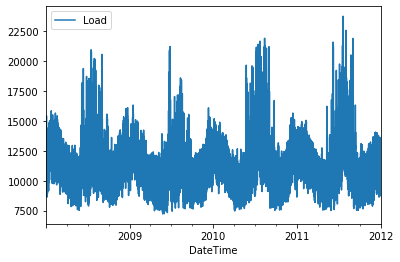

In [17]:
plot_data.plot();

## Plot Temperature against time

In [18]:
plot_data = data[['DateTime', 'Temperature']]
plot_data.set_index('DateTime', inplace = True)

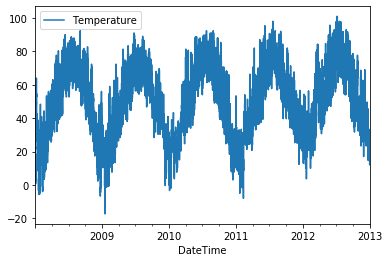

In [19]:
plot_data.plot();

In [20]:
data.groupby(['Temperature'])['Load'].mean()

Temperature
-17.33     13122.0
-17.00     12648.0
-16.33     13545.0
-15.67     13867.5
-15.33     13094.0
            ...   
 99.67         NaN
 100.00        NaN
 100.33        NaN
 100.67        NaN
 101.00        NaN
Name: Load, Length: 348, dtype: float64

## Corr of Temp and Load

In [21]:
corr_data = data[['Load', 'Temperature']]

In [22]:
corr_data.corr()

,Load,Temperature
Load,1.000000,0.250706
Temperature,0.250706,1.000000


## Plot Load against Temperature

In [23]:
corr_data = data[['Load', 'Temperature']]

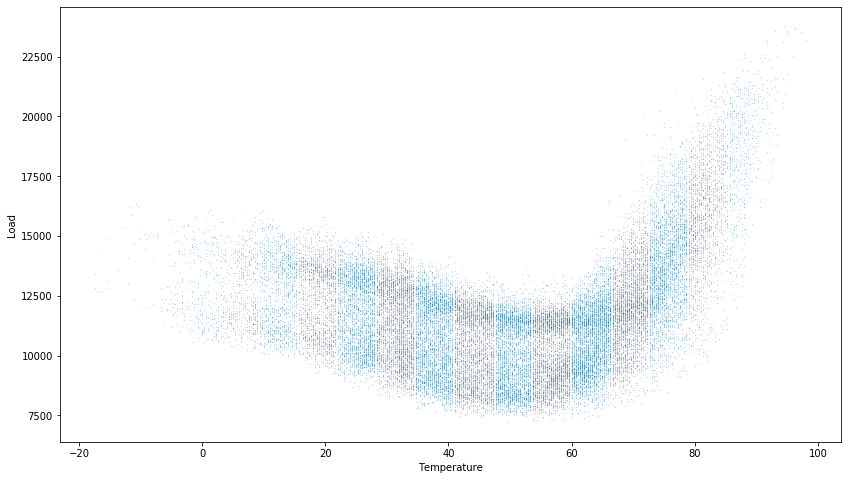

In [24]:
fig,ax=plt.subplots(figsize=(14,8))
corr_data.plot(x='Temperature', y='Load', kind = 'scatter',s=.01, ax=ax)

it's not linear, try log load

In [25]:
log_load = np.log(data['Load'])
x = data['Temperature']

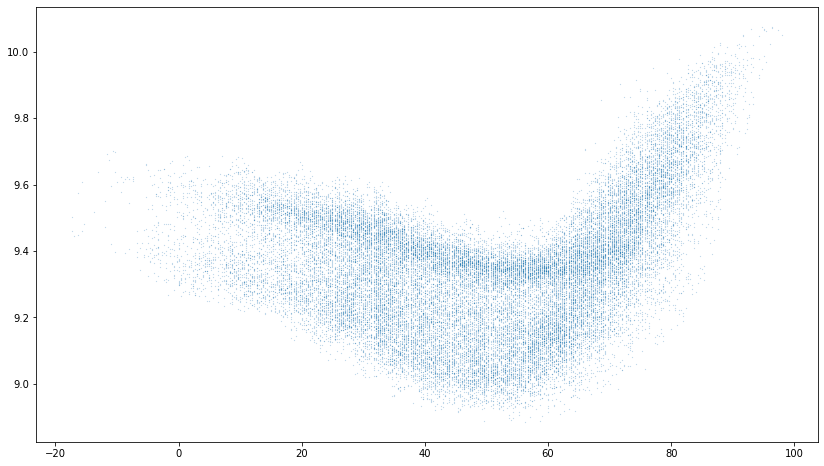

In [26]:
fig,ax=plt.subplots(figsize=(14,8))
ax.scatter(x=x, y=log_load,s=.01);

## Weekday

In [27]:
weekday_data = data[['DateTime', 'Load']].copy()
weekday = data['DateTime'].dt.dayofweek.tolist()
weekday_data['Weekday'] = weekday

In [28]:
weekday_data.head()

,DateTime,Load,Weekday
0,2008-01-01 01:00:00,10737.0,1
1,2008-01-01 02:00:00,10348.0,1
2,2008-01-01 03:00:00,9997.0,1
3,2008-01-01 04:00:00,9760.0,1
4,2008-01-01 05:00:00,9624.0,1


__The day of the week with Monday=0, Sunday=6.__

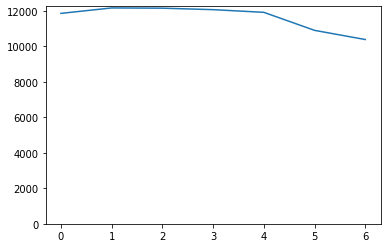

In [29]:
plt.plot(weekday_data.groupby(['Weekday'])['Load'].mean())
plt.ylim(ymin=0);

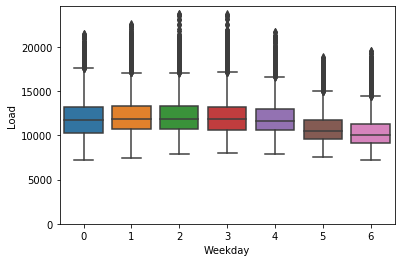

In [30]:
sns.boxplot(x='Weekday', y='Load', data = weekday_data)
plt.ylim(ymin=0);

In [31]:
weekday_data['Log(Load)'] = np.log(weekday_data['Load'])

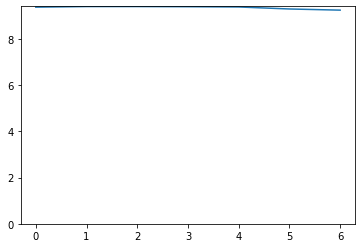

In [32]:
plt.plot(weekday_data.groupby(['Weekday'])['Log(Load)'].mean())
plt.ylim(ymin=0);

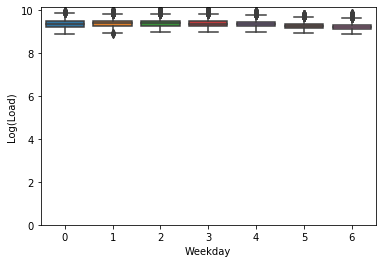

In [33]:
sns.boxplot(x='Weekday', y='Log(Load)', data = weekday_data)
plt.ylim(ymin=0);

## Weekend

In [34]:
weekend_data = data[['DateTime', 'Load']].copy()
weekend = data['DateTime'].dt.dayofweek.tolist()
weekend_data['Weekday'] = weekend

In [35]:
weekend_data['isWeekend'] = weekend_data['Weekday'].apply(lambda a: 1 if a in (5, 6) else 0)

__The day of the week with Monday=0, Sunday=6.__

In [36]:
weekend_data.head()

,DateTime,Load,Weekday,isWeekend
0,2008-01-01 01:00:00,10737.0,1,0
1,2008-01-01 02:00:00,10348.0,1,0
2,2008-01-01 03:00:00,9997.0,1,0
3,2008-01-01 04:00:00,9760.0,1,0
4,2008-01-01 05:00:00,9624.0,1,0


In [37]:
weekend_data.groupby(['isWeekend'])['Load'].mean()

isWeekend
0    12035.937777
1    10646.934459
Name: Load, dtype: float64

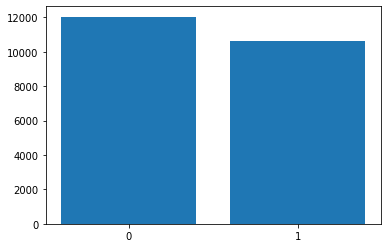

In [38]:
plt.bar(x=['0', '1'], height=weekend_data.groupby(['isWeekend'])['Load'].mean())
plt.ylim(ymin=0);

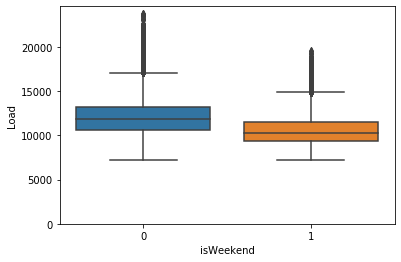

In [39]:
sns.boxplot(x='isWeekend', y='Load', data = weekend_data)
plt.ylim(ymin=0);

In [40]:
weekend_data['Log(Load)'] = np.log(weekend_data['Load'])

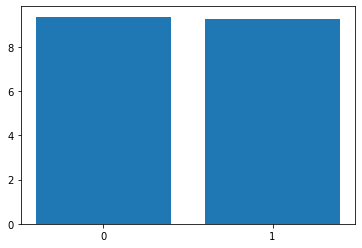

In [41]:
plt.bar(x=['0', '1'], height=weekend_data.groupby(['isWeekend'])['Log(Load)'].mean())
plt.ylim(ymin=0);

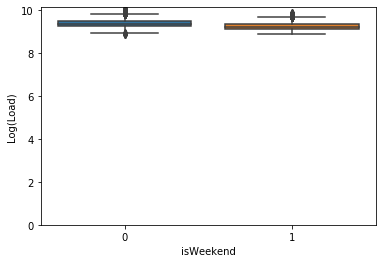

In [42]:
sns.boxplot(x='isWeekend', y='Log(Load)', data = weekend_data)
plt.ylim(ymin=0);

## Month

In [43]:
month_data = data[['DateTime', 'Load']].copy()

In [44]:
month_data['Month'] = month_data['DateTime'].dt.month.tolist()

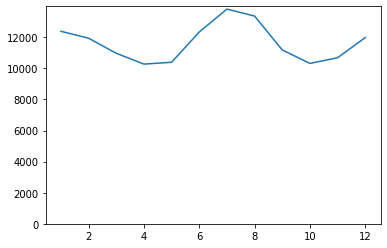

In [45]:
plt.plot(month_data.groupby(['Month'])['Load'].mean())
plt.ylim(ymin=0);

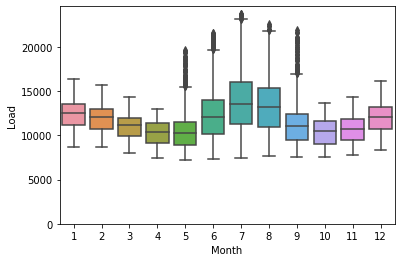

In [46]:
sns.boxplot(x='Month', y='Load', data = month_data)
plt.ylim(ymin=0);

In [47]:
month_data['Log(Load)'] = np.log(month_data['Load'])

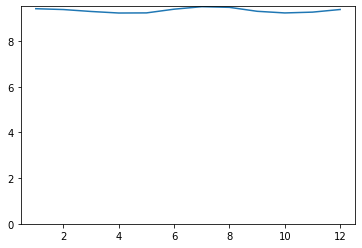

In [48]:
plt.plot(month_data.groupby(['Month'])['Log(Load)'].mean())
plt.ylim(ymin=0);

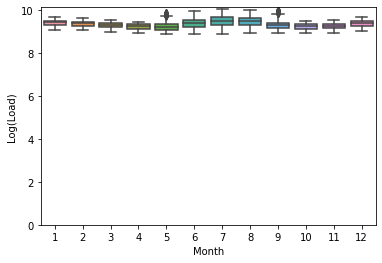

In [49]:
sns.boxplot(x='Month', y='Log(Load)', data = month_data)
plt.ylim(ymin=0);

## Year

In [50]:
year_data = data[['DateTime', 'Load']].copy()
year = data['DateTime'].dt.year
year_data['Year'] = year

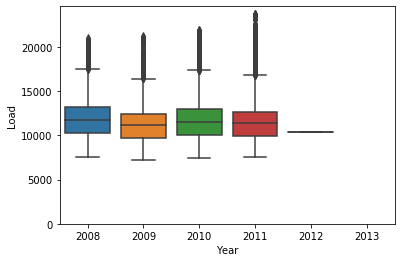

In [51]:
sns.boxplot(x='Year', y='Load',data=year_data)
plt.ylim(ymin=0);

# Create Features

In [52]:
X = data.copy()
X.pop('Date')
X.pop('Hour')
X = X[['Load', 'Temperature', 'DateTime']][:]
X.head()

,Load,Temperature,DateTime
0,10737.0,25.0,2008-01-01 01:00:00
1,10348.0,24.0,2008-01-01 02:00:00
2,9997.0,23.0,2008-01-01 03:00:00
3,9760.0,23.0,2008-01-01 04:00:00
4,9624.0,23.0,2008-01-01 05:00:00


## Temperature squared

In [53]:
X['Temperature_Squared'] = X['Temperature'] ** 2

In [54]:
X.head()

,Load,Temperature,DateTime,Temperature_Squared
0,10737.0,25.0,2008-01-01 01:00:00,625.0
1,10348.0,24.0,2008-01-01 02:00:00,576.0
2,9997.0,23.0,2008-01-01 03:00:00,529.0
3,9760.0,23.0,2008-01-01 04:00:00,529.0
4,9624.0,23.0,2008-01-01 05:00:00,529.0


## Weekday

In [55]:
X['Weekday'] = X['DateTime'].dt.dayofweek

In [56]:
X.head()

,Load,Temperature,DateTime,Temperature_Squared,Weekday
0,10737.0,25.0,2008-01-01 01:00:00,625.0,1
1,10348.0,24.0,2008-01-01 02:00:00,576.0,1
2,9997.0,23.0,2008-01-01 03:00:00,529.0,1
3,9760.0,23.0,2008-01-01 04:00:00,529.0,1
4,9624.0,23.0,2008-01-01 05:00:00,529.0,1


In [57]:
dummy_weekday = pd.get_dummies(X['Weekday'], prefix='Weekday')
dummy_weekday.head()

,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0


In [58]:
X = pd.concat([X, dummy_weekday], axis =1)

In [59]:
X.head()

,Load,Temperature,DateTime,Temperature_Squared,Weekday,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,10737.0,25.0,2008-01-01 01:00:00,625.0,1,0,1,0,0,0,0,0
1,10348.0,24.0,2008-01-01 02:00:00,576.0,1,0,1,0,0,0,0,0
2,9997.0,23.0,2008-01-01 03:00:00,529.0,1,0,1,0,0,0,0,0
3,9760.0,23.0,2008-01-01 04:00:00,529.0,1,0,1,0,0,0,0,0
4,9624.0,23.0,2008-01-01 05:00:00,529.0,1,0,1,0,0,0,0,0


In [60]:
X.pop('Weekday')

0        1
1        1
2        1
3        1
4        1
        ..
43843    0
43844    0
43845    0
43846    0
43847    1
Name: Weekday, Length: 43848, dtype: int64

## Month

In [61]:
X['Month'] = X['DateTime'].dt.month

In [62]:
X.head()

,Load,Temperature,DateTime,Temperature_Squared,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Month
0,10737.0,25.0,2008-01-01 01:00:00,625.0,0,1,0,0,0,0,0,1
1,10348.0,24.0,2008-01-01 02:00:00,576.0,0,1,0,0,0,0,0,1
2,9997.0,23.0,2008-01-01 03:00:00,529.0,0,1,0,0,0,0,0,1
3,9760.0,23.0,2008-01-01 04:00:00,529.0,0,1,0,0,0,0,0,1
4,9624.0,23.0,2008-01-01 05:00:00,529.0,0,1,0,0,0,0,0,1


In [63]:
dummy_month = pd.get_dummies(X['Month'], prefix='Month')
dummy_month.head()

,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


In [64]:
X = pd.concat([X, dummy_month], axis =1)
X.head()

,Load,Temperature,DateTime,Temperature_Squared,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,10737.0,25.0,2008-01-01 01:00:00,625.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10348.0,24.0,2008-01-01 02:00:00,576.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9997.0,23.0,2008-01-01 03:00:00,529.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9760.0,23.0,2008-01-01 04:00:00,529.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9624.0,23.0,2008-01-01 05:00:00,529.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
X.pop('Month')

0         1
1         1
2         1
3         1
4         1
         ..
43843    12
43844    12
43845    12
43846    12
43847     1
Name: Month, Length: 43848, dtype: int64

## Expert Variables

In [472]:
def yt(lag, data_yt):
    this_dataframe = data_yt.shift(periods = lag)
    # Trend
    this_dataframe['Trend'] = range(this_dataframe.shape[0])
    # Month of the year
    this_dataframe['Month'] = this_dataframe['DateTime'].dt.month
    # Day of the week
    this_dataframe['Week'] = this_dataframe['DateTime'].dt.dayofweek
    # Hour of the day
    this_dataframe['Hour'] = this_dataframe['DateTime'].dt.hour
    # I(Week, Hour)
    this_dataframe['Week_Hour'] = this_dataframe['Week'] * this_dataframe['Hour']
    this_dataframe.drop(['DateTime', 'Temperature'], inplace = True, axis = 1)
    return this_dataframe

def fofT(column, lag, data_fofT):
    this_dataframe = data_fofT.shift(periods = lag)
    # Temperatrue
    this_dataframe['Lag_'+ str(lag) +'_' + str(column)] = this_dataframe[column]
    # Temperatrue ** 2
    this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_2'] = this_dataframe[column] ** 2
    # Temperatrue ** 3
    this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_3'] = this_dataframe[column] ** 3
    # I(T, Month)
    this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_Month'] = this_dataframe[column] * this_dataframe['Month']
    # I(T_2, Month)
    this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_2_Month'] = this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_2'] * this_dataframe['Month']
    # I(T_3, Month)
    this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_3_Month'] = this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_3'] * this_dataframe['Month']
    # I(T, Hour)
    this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_Hour'] = this_dataframe[column] * this_dataframe['Hour']
    # I(T_2, Hour)
    this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_2_Hour'] = this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_2'] * this_dataframe['Hour']
    # I(T_3, Hour)
    this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_3_Hour'] = this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_3'] * this_dataframe['Hour']
    try:
        this_dataframe.drop(['DateTime', 'Month', 'Hour', column], inplace = True, axis = 1)
    except:
        pass
    return this_dataframe

In [473]:
# build the dataframe for fofT
data_fofT = data.copy()
data_fofT.drop(['Date', 'Hour', 'Load'], inplace = True, axis = 1)
data_fofT['Month'] = data_fofT['DateTime'].dt.month
data_fofT['Hour'] = data_fofT['DateTime'].dt.hour
# data_fofT.set_index('DateTime', inplace = True)
data_yt = data[['Load', 'Temperature', 'DateTime']][:]
data_rolling = data_fofT.copy()
data_rolling['Temperature_Rolling_last_24hour'] = data_rolling['Temperature'].shift(1).rolling(window=24).mean()
data_rolling.drop('Temperature', inplace = True, axis = 1)
base_data = yt(0, data_yt)
X_build_model = base_data[:]
for h in range(73):
    lag_h = fofT('Temperature', h, data_fofT)
    X_build_model = pd.concat([X_build_model, lag_h], axis = 1)
for day in range(1, 8):
    lag_day = fofT('Temperature_Rolling_last_24hour', (day-1) * 24, data_rolling)
    X_build_model = pd.concat([X_build_model, lag_day], axis = 1)

In [474]:
X_build_model.index = data['DateTime']

# Feature Selection

In [487]:
X_train = X_build_model[:'2010-12-31'].dropna()
X_train_x, X_train_y = X_train.drop('Load', axis = 1), X_train['Load']
X_test = X_build_model['2011-01-01':'2011-12-31'].dropna()
X_test_x, X_test_y = X_test.drop('Load', axis = 1), X_test['Load']

In [476]:
estimator = LinearRegression()
selector = RFE(estimator, 50, step=1)
selector = selector.fit(X_train_x, X_train_y)

In [488]:
X_train_x_Sed = X_train_x[X_train_x.columns[selector.support_]]
X_test_x_Sed = X_test_x[X_test_x.columns[selector.support_]]

# Build Models

In [70]:
X_build_model = X.drop(['DateTime'], axis=1)

In [71]:
X_build_model = X_build_model.dropna()

In [72]:
X_build_model.head()

,Load,Temperature,Temperature_Squared,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,10737.0,25.0,625.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10348.0,24.0,576.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9997.0,23.0,529.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9760.0,23.0,529.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9624.0,23.0,529.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Holt-Winter's 

### Train Test Split

In [77]:
X_train = X[X['DateTime'] <= '2010-12-31']['Load']

### Model Building

In [79]:
model_HW = ExponentialSmoothing(X_train, seasonal='add', seasonal_periods=24 * 365)

In [81]:
model_HW = model_HW.fit()

/Users/chengyinliu/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


### MAPE

In [104]:
X_test = X[(X['DateTime'] >= '2011-01-01') & (X['DateTime'] <= '2011-12-31')]['Load']

In [107]:
X[(X['DateTime'] >= '2011-01-01') & (X['DateTime'] <= '2011-12-31')]

,Load,Temperature,DateTime,Temperature_Squared,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
26303,10042.0,41.33,2011-01-01 00:00:00,1708.1689,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
26304,9627.0,39.33,2011-01-01 01:00:00,1546.8489,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
26305,9268.0,36.67,2011-01-01 02:00:00,1344.6889,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
26306,9007.0,35.33,2011-01-01 03:00:00,1248.2089,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
26307,8737.0,32.00,2011-01-01 04:00:00,1024.0000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,12248.0,39.00,2011-12-30 20:00:00,1521.0000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
35036,12023.0,38.00,2011-12-30 21:00:00,1444.0000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
35037,11717.0,37.33,2011-12-30 22:00:00,1393.5289,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
35038,11318.0,36.33,2011-12-30 23:00:00,1319.8689,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [105]:
yhat = model_HW.forecast(len(X_test))

In [108]:
len(pd.date_range('2011-01-01 00:00:00', '2011-12-31 00:00:00', freq = 'H'))

8737

In [109]:
yhat.index = pd.date_range('2011-01-01 00:00:00', '2011-12-31 00:00:00', freq = 'H')
X_test.index = pd.date_range('2011-01-01 00:00:00', '2011-12-31 00:00:00', freq = 'H')

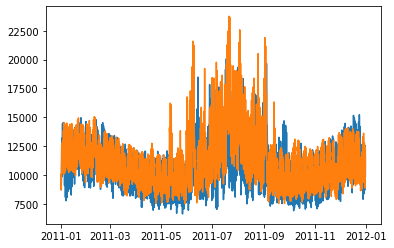

In [110]:
plt.plot(yhat)
plt.plot(X_test)
# plt.xticks(pd.date_range('2011-01-01 00:00:00', '2012-12-31 23:00:00', freq = 'H'))

In [112]:
mape(X_test, yhat)

13.151412124791815

## Linear Regression

### Train Test Split (Without Cross Validation)

In [59]:
X_train, X_test = train_test_split(X_build_model, test_size=0.2, random_state=0)

In [60]:
X_train.shape, X_test.shape

((28051, 22), (7013, 22))

In [61]:
X_train_x = X_train.drop(['Load'], axis = 1)
X_train_y = X_train['Load']

In [62]:
X_test_x = X_test.drop(['Load'], axis = 1)
X_test_y = X_test['Load']

In [63]:
X_test_x.columns

Index(['Temperature', 'Temperature_Squared', 'Weekday_0', 'Weekday_1',
       'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12'],
      dtype='object')

### Model Building

In [64]:
model_lm = LinearRegression()

In [65]:
model_lm.fit(X_train_x, X_train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [66]:
model_lm.score(X_train_x, X_train_y)

0.6046915733117858

### MAPE

In [68]:
mape(X_train_y, model_lm.predict(X_train_x))

10.5189076107735

In [69]:
mape(X_test_y, model_lm.predict(X_test_x))

10.455508721939147

## Tao’s vanilla benchmark model

### Build its own variables

In [113]:
# build the dataframe for fofT
data_fofT = data.copy()
data_fofT.drop(['Date', 'Hour', 'Load'], inplace = True, axis = 1)
data_fofT.head()

,Temperature,DateTime
0,25.0,2008-01-01 01:00:00
1,24.0,2008-01-01 02:00:00
2,23.0,2008-01-01 03:00:00
3,23.0,2008-01-01 04:00:00
4,23.0,2008-01-01 05:00:00


In [114]:
data_fofT['Month'] = data_fofT['DateTime'].dt.month
data_fofT['Hour'] = data_fofT['DateTime'].dt.hour
# data_fofT.set_index('DateTime', inplace = True)
data_fofT.head()

,Temperature,DateTime,Month,Hour
0,25.0,2008-01-01 01:00:00,1,1
1,24.0,2008-01-01 02:00:00,1,2
2,23.0,2008-01-01 03:00:00,1,3
3,23.0,2008-01-01 04:00:00,1,4
4,23.0,2008-01-01 05:00:00,1,5


In [115]:
data_yt = data[['Load', 'Temperature', 'DateTime']][:]
data_yt.head()

,Load,Temperature,DateTime
0,10737.0,25.0,2008-01-01 01:00:00
1,10348.0,24.0,2008-01-01 02:00:00
2,9997.0,23.0,2008-01-01 03:00:00
3,9760.0,23.0,2008-01-01 04:00:00
4,9624.0,23.0,2008-01-01 05:00:00


In [116]:
def yt(lag, data_yt):
    this_dataframe = data_yt.shift(periods = lag)
    # Trend
    this_dataframe['Trend'] = range(this_dataframe.shape[0])
    # Month of the year
    this_dataframe['Month'] = this_dataframe['DateTime'].dt.month
    # Day of the week
    this_dataframe['Week'] = this_dataframe['DateTime'].dt.dayofweek
    # Hour of the day
    this_dataframe['Hour'] = this_dataframe['DateTime'].dt.hour
    # I(Week, Hour)
    this_dataframe['Week_Hour'] = this_dataframe['Week'] * this_dataframe['Hour']
    this_dataframe.drop(['DateTime', 'Temperature'], inplace = True, axis = 1)
    return this_dataframe

def fofT(column, lag, data_fofT):
    this_dataframe = data_fofT.shift(periods = lag)
    # Temperatrue
    this_dataframe['Lag_'+ str(lag) +'_' + str(column)] = this_dataframe[column]
    # Temperatrue ** 2
    this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_2'] = this_dataframe[column] ** 2
    # Temperatrue ** 3
    this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_3'] = this_dataframe[column] ** 3
    # I(T, Month)
    this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_Month'] = this_dataframe[column] * this_dataframe['Month']
    # I(T_2, Month)
    this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_2_Month'] = this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_2'] * this_dataframe['Month']
    # I(T_3, Month)
    this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_3_Month'] = this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_3'] * this_dataframe['Month']
    # I(T, Hour)
    this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_Hour'] = this_dataframe[column] * this_dataframe['Hour']
    # I(T_2, Hour)
    this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_2_Hour'] = this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_2'] * this_dataframe['Hour']
    # I(T_3, Hour)
    this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_3_Hour'] = this_dataframe['Lag_'+ str(lag) +'_' + str(column) + '_3'] * this_dataframe['Hour']
    try:
        this_dataframe.drop(['DateTime', 'Month', 'Hour', column], inplace = True, axis = 1)
    except:
        pass
    return this_dataframe

In [117]:
X_build_model = pd.concat([yt(0, data_yt), fofT('Temperature', 0, data_fofT)], axis = 1)

In [118]:
X_build_model.head()

,Load,Trend,Month,Week,Hour,Week_Hour,Lag_0_Temperature,Lag_0_Temperature_2,Lag_0_Temperature_3,Lag_0_Temperature_Month,Lag_0_Temperature_2_Month,Lag_0_Temperature_3_Month,Lag_0_Temperature_Hour,Lag_0_Temperature_2_Hour,Lag_0_Temperature_3_Hour
0,10737.0,0,1,1,1,1,25.0,625.0,15625.0,25.0,625.0,15625.0,25.0,625.0,15625.0
1,10348.0,1,1,1,2,2,24.0,576.0,13824.0,24.0,576.0,13824.0,48.0,1152.0,27648.0
2,9997.0,2,1,1,3,3,23.0,529.0,12167.0,23.0,529.0,12167.0,69.0,1587.0,36501.0
3,9760.0,3,1,1,4,4,23.0,529.0,12167.0,23.0,529.0,12167.0,92.0,2116.0,48668.0
4,9624.0,4,1,1,5,5,23.0,529.0,12167.0,23.0,529.0,12167.0,115.0,2645.0,60835.0


In [119]:
X_build_model.columns, len(X_build_model.columns)

(Index(['Load', 'Trend', 'Month', 'Week', 'Hour', 'Week_Hour',
        'Lag_0_Temperature', 'Lag_0_Temperature_2', 'Lag_0_Temperature_3',
        'Lag_0_Temperature_Month', 'Lag_0_Temperature_2_Month',
        'Lag_0_Temperature_3_Month', 'Lag_0_Temperature_Hour',
        'Lag_0_Temperature_2_Hour', 'Lag_0_Temperature_3_Hour'],
       dtype='object'), 15)

### Train Test Split

In [77]:
X_train, X_test = train_test_split(X_build_model.dropna(), test_size=0.2, random_state=0)

In [78]:
X_train.shape, X_test.shape

((28051, 15), (7013, 15))

In [79]:
X_train_x = X_train.drop(['Load'], axis = 1)
X_train_y = X_train['Load']

In [80]:
X_test_x = X_test.drop(['Load'], axis = 1)
X_test_y = X_test['Load']

In [81]:
X_test_x.columns

Index(['Trend', 'Month', 'Week', 'Hour', 'Week_Hour', 'Lag_0_Temperature',
       'Lag_0_Temperature_2', 'Lag_0_Temperature_3', 'Lag_0_Temperature_Month',
       'Lag_0_Temperature_2_Month', 'Lag_0_Temperature_3_Month',
       'Lag_0_Temperature_Hour', 'Lag_0_Temperature_2_Hour',
       'Lag_0_Temperature_3_Hour'],
      dtype='object')

### Model Building

In [82]:
model_benchmark = LinearRegression()

In [83]:
model_benchmark.fit(X_train_x, X_train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [84]:
model_benchmark.score(X_train_x, X_train_y)

0.7464064935836154

### MAPE

In [85]:
mape(X_train_y, model_benchmark.predict(X_train_x))

8.03775976797695

In [86]:
mape(X_test_y, model_benchmark.predict(X_test_x))

7.960072876906881

## Capture Recency effect

### Build its own variables

In [160]:
data_rolling = data_fofT.copy()
data_rolling.head()

,Temperature,DateTime,Month,Hour
0,25.0,2008-01-01 01:00:00,1,1
1,24.0,2008-01-01 02:00:00,1,2
2,23.0,2008-01-01 03:00:00,1,3
3,23.0,2008-01-01 04:00:00,1,4
4,23.0,2008-01-01 05:00:00,1,5


In [161]:
data_rolling['Temperature_Rolling_last_24hour'] = data_rolling['Temperature'].shift(1).rolling(window=24).mean()
data_rolling.drop('Temperature', inplace = True, axis = 1)

In [162]:
data_rolling.iloc[20:40, :]

,DateTime,Month,Hour,Temperature_Rolling_last_24hour
20,2008-01-01 21:00:00,1,21,NaN
21,2008-01-01 22:00:00,1,22,NaN
22,2008-01-01 23:00:00,1,23,NaN
23,2008-01-02 00:00:00,1,0,NaN
24,2008-01-02 01:00:00,1,1,17.415833
25,2008-01-02 02:00:00,1,2,16.499167
26,2008-01-02 03:00:00,1,3,15.610417
27,2008-01-02 04:00:00,1,4,14.735417
28,2008-01-02 05:00:00,1,5,13.874167
29,2008-01-02 06:00:00,1,6,13.040833


In [163]:
base_data = yt(0, data_yt)

In [164]:
base_data.head()

,Load,Trend,Month,Week,Hour,Week_Hour
0,10737.0,0,1,1,1,1
1,10348.0,1,1,1,2,2
2,9997.0,2,1,1,3,3
3,9760.0,3,1,1,4,4
4,9624.0,4,1,1,5,5


In [165]:
X_build_model = base_data[:]

In [166]:
for h in range(73):
    lag_h = fofT('Temperature', h, data_fofT)
    X_build_model = pd.concat([X_build_model, lag_h], axis = 1)

In [167]:
for day in range(1, 8):
    lag_day = fofT('Temperature_Rolling_last_24hour', (day-1) * 24, data_rolling)
    X_build_model = pd.concat([X_build_model, lag_day], axis = 1)

In [168]:
list(X_build_model.columns)

['Load',
 'Trend',
 'Month',
 'Week',
 'Hour',
 'Week_Hour',
 'Lag_0_Temperature',
 'Lag_0_Temperature_2',
 'Lag_0_Temperature_3',
 'Lag_0_Temperature_Month',
 'Lag_0_Temperature_2_Month',
 'Lag_0_Temperature_3_Month',
 'Lag_0_Temperature_Hour',
 'Lag_0_Temperature_2_Hour',
 'Lag_0_Temperature_3_Hour',
 'Lag_1_Temperature',
 'Lag_1_Temperature_2',
 'Lag_1_Temperature_3',
 'Lag_1_Temperature_Month',
 'Lag_1_Temperature_2_Month',
 'Lag_1_Temperature_3_Month',
 'Lag_1_Temperature_Hour',
 'Lag_1_Temperature_2_Hour',
 'Lag_1_Temperature_3_Hour',
 'Lag_2_Temperature',
 'Lag_2_Temperature_2',
 'Lag_2_Temperature_3',
 'Lag_2_Temperature_Month',
 'Lag_2_Temperature_2_Month',
 'Lag_2_Temperature_3_Month',
 'Lag_2_Temperature_Hour',
 'Lag_2_Temperature_2_Hour',
 'Lag_2_Temperature_3_Hour',
 'Lag_3_Temperature',
 'Lag_3_Temperature_2',
 'Lag_3_Temperature_3',
 'Lag_3_Temperature_Month',
 'Lag_3_Temperature_2_Month',
 'Lag_3_Temperature_3_Month',
 'Lag_3_Temperature_Hour',
 'Lag_3_Temperature_2_Hou

### Train Test Split

In [169]:
X_train, X_test = train_test_split(X_build_model.dropna(), test_size=0.2, random_state=0)

In [170]:
X_train.shape, X_test.shape

((27916, 726), (6980, 726))

In [171]:
X_train_x = X_train.drop(['Load'], axis = 1)
X_train_y = X_train['Load']

In [172]:
X_test_x = X_test.drop(['Load'], axis = 1)
X_test_y = X_test['Load']

In [173]:
X_test_x.columns

Index(['Trend', 'Month', 'Week', 'Hour', 'Week_Hour', 'Lag_0_Temperature',
       'Lag_0_Temperature_2', 'Lag_0_Temperature_3', 'Lag_0_Temperature_Month',
       'Lag_0_Temperature_2_Month',
       ...
       'Lag_120_Temperature_Rolling_last_24hour_3_Hour',
       'Lag_144_Temperature_Rolling_last_24hour',
       'Lag_144_Temperature_Rolling_last_24hour_2',
       'Lag_144_Temperature_Rolling_last_24hour_3',
       'Lag_144_Temperature_Rolling_last_24hour_Month',
       'Lag_144_Temperature_Rolling_last_24hour_2_Month',
       'Lag_144_Temperature_Rolling_last_24hour_3_Month',
       'Lag_144_Temperature_Rolling_last_24hour_Hour',
       'Lag_144_Temperature_Rolling_last_24hour_2_Hour',
       'Lag_144_Temperature_Rolling_last_24hour_3_Hour'],
      dtype='object', length=725)

### Model Building

In [174]:
model_capture_rencency = LinearRegression()

In [175]:
model_capture_rencency.fit(X_train_x, X_train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [176]:
model_capture_rencency.score(X_train_x, X_train_y)

0.910264522715298

### MAPE

In [177]:
mape(X_train_y, model_capture_rencency.predict(X_train_x))

4.66836167754187

In [178]:
mape(X_test_y, model_capture_rencency.predict(X_test_x))

4.695887657566677

### Try Feature Selection

In [182]:
estimator = LinearRegression()
selector = RFE(estimator, 50, step=1)
selector = selector.fit(X_train_x, X_train_y)

In [187]:
len(X_train_x.columns), len(selector.support_)

(725, 725)

In [188]:
X_train_x.columns[selector.support_]

Index(['Month', 'Week', 'Hour', 'Week_Hour', 'Lag_1_Temperature',
       'Lag_3_Temperature', 'Lag_5_Temperature', 'Lag_6_Temperature',
       'Lag_8_Temperature', 'Lag_9_Temperature', 'Lag_10_Temperature',
       'Lag_13_Temperature', 'Lag_14_Temperature', 'Lag_14_Temperature_Month',
       'Lag_15_Temperature', 'Lag_16_Temperature', 'Lag_16_Temperature_Month',
       'Lag_17_Temperature', 'Lag_19_Temperature', 'Lag_20_Temperature',
       'Lag_21_Temperature', 'Lag_22_Temperature', 'Lag_23_Temperature',
       'Lag_25_Temperature', 'Lag_28_Temperature', 'Lag_32_Temperature',
       'Lag_34_Temperature', 'Lag_38_Temperature', 'Lag_44_Temperature',
       'Lag_45_Temperature', 'Lag_46_Temperature', 'Lag_47_Temperature',
       'Lag_52_Temperature', 'Lag_53_Temperature', 'Lag_56_Temperature',
       'Lag_57_Temperature', 'Lag_58_Temperature', 'Lag_61_Temperature',
       'Lag_62_Temperature', 'Lag_65_Temperature', 'Lag_68_Temperature',
       'Lag_69_Temperature', 'Lag_71_Temperature', 

## XGBoost

### Train Test Split

In [436]:
X_build_model.head()

,Load,Trend,Month,Week,Hour,Week_Hour,Lag_0_Temperature,Lag_0_Temperature_2,Lag_0_Temperature_3,Lag_0_Temperature_Month,...,Lag_120_Temperature_Rolling_last_24hour_3_Hour,Lag_144_Temperature_Rolling_last_24hour,Lag_144_Temperature_Rolling_last_24hour_2,Lag_144_Temperature_Rolling_last_24hour_3,Lag_144_Temperature_Rolling_last_24hour_Month,Lag_144_Temperature_Rolling_last_24hour_2_Month,Lag_144_Temperature_Rolling_last_24hour_3_Month,Lag_144_Temperature_Rolling_last_24hour_Hour,Lag_144_Temperature_Rolling_last_24hour_2_Hour,Lag_144_Temperature_Rolling_last_24hour_3_Hour
DateTime,,,,,,,,,,,,,,,,,,,,,
2008-01-01 01:00:00,10737.0,0,1,1,1,1,25.0,625.0,15625.0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 02:00:00,10348.0,1,1,1,2,2,24.0,576.0,13824.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 03:00:00,9997.0,2,1,1,3,3,23.0,529.0,12167.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 04:00:00,9760.0,3,1,1,4,4,23.0,529.0,12167.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-01 05:00:00,9624.0,4,1,1,5,5,23.0,529.0,12167.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [437]:
X_build_model.index = data['DateTime']

In [438]:
X_train = X_build_model[:'2010-12-31'][:]
X_train.tail()

,Load,Trend,Month,Week,Hour,Week_Hour,Lag_0_Temperature,Lag_0_Temperature_2,Lag_0_Temperature_3,Lag_0_Temperature_Month,...,Lag_120_Temperature_Rolling_last_24hour_3_Hour,Lag_144_Temperature_Rolling_last_24hour,Lag_144_Temperature_Rolling_last_24hour_2,Lag_144_Temperature_Rolling_last_24hour_3,Lag_144_Temperature_Rolling_last_24hour_Month,Lag_144_Temperature_Rolling_last_24hour_2_Month,Lag_144_Temperature_Rolling_last_24hour_3_Month,Lag_144_Temperature_Rolling_last_24hour_Hour,Lag_144_Temperature_Rolling_last_24hour_2_Hour,Lag_144_Temperature_Rolling_last_24hour_3_Hour
DateTime,,,,,,,,,,,,,,,,,,,,,
2010-12-31 19:00:00,11735.0,26298,12,4,19,76,53.33,2844.0889,151675.261037,639.96,...,378008.188263,27.778333,771.635803,21434.756541,333.340,9259.629633,257217.078498,527.788333,14661.080253,407260.374288
2010-12-31 20:00:00,11585.0,26299,12,4,20,80,53.33,2844.0889,151675.261037,639.96,...,391822.142541,27.736667,769.322678,21338.446673,332.840,9231.872133,256061.360072,554.733333,15386.453556,426768.933453
2010-12-31 21:00:00,11243.0,26300,12,4,21,84,52.33,2738.4289,143301.984337,627.96,...,402587.409063,27.708750,767.774827,21274.080726,332.505,9213.297919,255288.968706,581.883750,16123.271358,446755.695236
2010-12-31 22:00:00,10825.0,26301,12,4,22,88,51.33,2634.7689,135242.687637,615.96,...,411985.604310,27.680833,766.228534,21209.844346,332.170,9194.742408,254518.132148,608.978333,16857.027749,466616.575605
2010-12-31 23:00:00,10511.0,26302,12,4,23,92,48.33,2335.7889,112888.677537,579.96,...,418005.685258,27.652917,764.683800,21145.737403,331.835,9176.205602,253748.848831,636.017083,17587.727404,486351.960259


In [322]:
X_train.dropna(inplace = True)

In [394]:
X_train_x, X_train_y = X_train.drop('Load', axis = 1), X_train['Load']

In [395]:
X_test = X_build_model['2011-01-01':'2011-12-31'][:]
X_test.tail()

,Load,Temperature,Temperature_Squared,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-12-31 19:00:00,11907.0,38.67,1495.3689,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2011-12-31 20:00:00,11812.0,39.33,1546.8489,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2011-12-31 21:00:00,11542.0,39.33,1546.8489,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2011-12-31 22:00:00,11149.0,39.00,1521.0000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2011-12-31 23:00:00,10855.0,39.33,1546.8489,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [396]:
X_test_x, X_test_y = X_test.drop('Load', axis = 1), X_test['Load']

### Feature Selection

In [397]:
estimator = LinearRegression()
selector = RFE(estimator, 50, step=1)
selector = selector.fit(X_train_x, X_train_y)

In [398]:
len(X_train_x.columns), len(selector.support_)

(21, 21)

In [399]:
X_train_x.columns[selector.support_]

Index(['Temperature', 'Temperature_Squared', 'Weekday_0', 'Weekday_1',
       'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6',
       'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
       'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12'],
      dtype='object')

In [358]:
X_train_x_Sed = X_train_x[X_train_x.columns[selector.support_]]

In [359]:
X_train_x_Sed.shape

(26135, 20)

### Model Building

In [483]:
model = xgb.XGBRegressor(max_depth=3, 
                         learning_rate=0.1, 
                         n_estimators=300, 
                         silent=True, 
                         objective="reg:linear", 
                         eval_metric='rmse', 
                         seed=0, 
                         reg_alpha=0.5)

model.fit(X_train_x_Sed, X_train_y)

/Users/chengyinliu/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/chengyinliu/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=300, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1,
             seed=0, silent=True, subsample=1, verbosity=1)

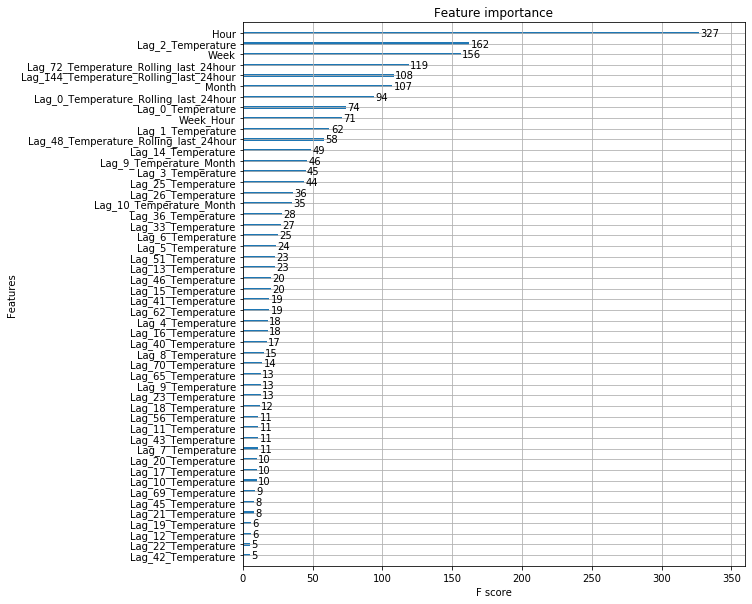

In [484]:
fig, ax = plt.subplots(figsize=(9, 10))
xgb.plot_importance(model, ax = ax)

In [485]:
mape(X_train_y, model.predict(X_train_x_Sed)) 

2.4940943991192346

In [489]:
mape(X_test_y, model.predict(X_test_x_Sed)) 

3.024759908406691

In [490]:
mape(X_test_y, model.predict(X_test_x_Sed))  - mape(X_train_y, model.predict(X_train_x_Sed)) 

0.5306655092874566

## Neural Network

### Train Test Split

In [110]:
X_build_model = X.drop(['DateTime'], axis=1)

In [111]:
X_train, X_test = train_test_split(X_build_model, test_size=0.2, random_state=0)

In [112]:
X_train.shape, X_test.shape

((35078, 22), (8770, 22))

In [113]:
X_train_x = X_train.drop(['Load', 'Temperature_Squared'], axis = 1)
X_train_y = X_train['Load']

In [114]:
X_test_x = X_test.drop(['Load'], axis = 1)
X_test_y = X_test['Load']

In [439]:
## New

In [441]:
X_train = X_build_model[:'2010-12-31'].dropna()
X_train.tail()

,Load,Trend,Month,Week,Hour,Week_Hour,Lag_0_Temperature,Lag_0_Temperature_2,Lag_0_Temperature_3,Lag_0_Temperature_Month,...,Lag_120_Temperature_Rolling_last_24hour_3_Hour,Lag_144_Temperature_Rolling_last_24hour,Lag_144_Temperature_Rolling_last_24hour_2,Lag_144_Temperature_Rolling_last_24hour_3,Lag_144_Temperature_Rolling_last_24hour_Month,Lag_144_Temperature_Rolling_last_24hour_2_Month,Lag_144_Temperature_Rolling_last_24hour_3_Month,Lag_144_Temperature_Rolling_last_24hour_Hour,Lag_144_Temperature_Rolling_last_24hour_2_Hour,Lag_144_Temperature_Rolling_last_24hour_3_Hour
DateTime,,,,,,,,,,,,,,,,,,,,,
2010-12-31 19:00:00,11735.0,26298,12,4,19,76,53.33,2844.0889,151675.261037,639.96,...,378008.188263,27.778333,771.635803,21434.756541,333.340,9259.629633,257217.078498,527.788333,14661.080253,407260.374288
2010-12-31 20:00:00,11585.0,26299,12,4,20,80,53.33,2844.0889,151675.261037,639.96,...,391822.142541,27.736667,769.322678,21338.446673,332.840,9231.872133,256061.360072,554.733333,15386.453556,426768.933453
2010-12-31 21:00:00,11243.0,26300,12,4,21,84,52.33,2738.4289,143301.984337,627.96,...,402587.409063,27.708750,767.774827,21274.080726,332.505,9213.297919,255288.968706,581.883750,16123.271358,446755.695236
2010-12-31 22:00:00,10825.0,26301,12,4,22,88,51.33,2634.7689,135242.687637,615.96,...,411985.604310,27.680833,766.228534,21209.844346,332.170,9194.742408,254518.132148,608.978333,16857.027749,466616.575605
2010-12-31 23:00:00,10511.0,26302,12,4,23,92,48.33,2335.7889,112888.677537,579.96,...,418005.685258,27.652917,764.683800,21145.737403,331.835,9176.205602,253748.848831,636.017083,17587.727404,486351.960259


In [442]:
X_train_x, X_train_y = X_train.drop('Load', axis = 1), X_train['Load']

In [443]:
X_test = X_build_model['2011-01-01':'2011-12-31'].dropna()
X_test.tail()

,Load,Trend,Month,Week,Hour,Week_Hour,Lag_0_Temperature,Lag_0_Temperature_2,Lag_0_Temperature_3,Lag_0_Temperature_Month,...,Lag_120_Temperature_Rolling_last_24hour_3_Hour,Lag_144_Temperature_Rolling_last_24hour,Lag_144_Temperature_Rolling_last_24hour_2,Lag_144_Temperature_Rolling_last_24hour_3,Lag_144_Temperature_Rolling_last_24hour_Month,Lag_144_Temperature_Rolling_last_24hour_2_Month,Lag_144_Temperature_Rolling_last_24hour_3_Month,Lag_144_Temperature_Rolling_last_24hour_Hour,Lag_144_Temperature_Rolling_last_24hour_2_Hour,Lag_144_Temperature_Rolling_last_24hour_3_Hour
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-12-31 19:00:00,11907.0,35058,12,5,19,95,38.67,1495.3689,57825.915363,464.04,...,717836.158149,37.931250,1438.779727,54574.713503,455.175,17265.356719,654896.562038,720.693750,27336.814805,1.036920e+06
2011-12-31 20:00:00,11812.0,35059,12,5,20,100,39.33,1546.8489,60837.567237,471.96,...,767899.390724,37.903333,1436.662678,54454.304363,454.840,17239.952133,653451.652360,758.066667,28733.253556,1.089086e+06
2011-12-31 21:00:00,11542.0,35060,12,5,21,105,39.33,1546.8489,60837.567237,471.96,...,823322.259072,37.806250,1429.312539,54036.947180,453.675,17151.750469,648443.366159,793.931250,30015.563320,1.134776e+06
2011-12-31 22:00:00,11149.0,35061,12,5,22,110,39.00,1521.0000,59319.000000,468.00,...,884935.290669,37.681250,1419.876602,53502.725193,452.175,17038.519219,642032.702312,828.987500,31237.285234,1.177060e+06
2011-12-31 23:00:00,10855.0,35062,12,5,23,115,39.33,1546.8489,60837.567237,471.96,...,951289.472275,37.500417,1406.281250,52736.132832,450.005,16875.375002,632833.593984,862.509583,32344.468754,1.212931e+06


In [444]:
X_test_x, X_test_y = X_test.drop('Load', axis = 1), X_test['Load']

### Feature Selection

In [445]:
estimator = LinearRegression()
selector = RFE(estimator, 50, step=1)
selector = selector.fit(X_train_x, X_train_y)

In [446]:
len(X_train_x.columns), len(selector.support_)

(725, 725)

In [447]:
X_train_x.columns[selector.support_]

Index(['Month', 'Week', 'Hour', 'Week_Hour', 'Lag_0_Temperature',
       'Lag_1_Temperature', 'Lag_2_Temperature', 'Lag_3_Temperature',
       'Lag_4_Temperature', 'Lag_5_Temperature', 'Lag_6_Temperature',
       'Lag_7_Temperature', 'Lag_8_Temperature', 'Lag_9_Temperature',
       'Lag_9_Temperature_Month', 'Lag_10_Temperature',
       'Lag_10_Temperature_Month', 'Lag_11_Temperature', 'Lag_12_Temperature',
       'Lag_13_Temperature', 'Lag_14_Temperature', 'Lag_15_Temperature',
       'Lag_16_Temperature', 'Lag_17_Temperature', 'Lag_18_Temperature',
       'Lag_19_Temperature', 'Lag_20_Temperature', 'Lag_21_Temperature',
       'Lag_22_Temperature', 'Lag_23_Temperature', 'Lag_25_Temperature',
       'Lag_26_Temperature', 'Lag_33_Temperature', 'Lag_36_Temperature',
       'Lag_40_Temperature', 'Lag_41_Temperature', 'Lag_42_Temperature',
       'Lag_43_Temperature', 'Lag_45_Temperature', 'Lag_46_Temperature',
       'Lag_51_Temperature', 'Lag_56_Temperature', 'Lag_62_Temperature',
     

In [448]:
X_train_x_Sed = X_train_x[X_train_x.columns[selector.support_]]

In [449]:
X_train_x_Sed.shape

(26135, 50)

In [466]:
X_train_x_Sed.head()

,Month,Week,Hour,Week_Hour,Lag_0_Temperature,Lag_1_Temperature,Lag_2_Temperature,Lag_3_Temperature,Lag_4_Temperature,Lag_5_Temperature,...,Lag_51_Temperature,Lag_56_Temperature,Lag_62_Temperature,Lag_65_Temperature,Lag_69_Temperature,Lag_70_Temperature,Lag_0_Temperature_Rolling_last_24hour,Lag_48_Temperature_Rolling_last_24hour,Lag_72_Temperature_Rolling_last_24hour,Lag_144_Temperature_Rolling_last_24hour
DateTime,,,,,,,,,,,,,,,,,,,,,
2008-01-08 01:00:00,1,1,1,1,54.00,53.33,54.00,53.67,55.00,55.33,...,41.33,41.00,38.67,36.33,35.67,36.67,56.777917,38.736250,28.138750,17.415833
2008-01-08 02:00:00,1,1,2,2,54.67,54.00,53.33,54.00,53.67,55.00,...,41.67,41.33,39.33,36.67,36.00,35.67,56.958333,38.986250,28.680417,16.499167
2008-01-08 03:00:00,1,1,3,3,54.33,54.67,54.00,53.33,54.00,53.67,...,39.33,41.00,39.67,37.67,36.67,36.00,57.166667,39.152917,29.263750,15.610417
2008-01-08 04:00:00,1,1,4,4,54.00,54.33,54.67,54.00,53.33,54.00,...,41.33,40.67,40.33,38.67,36.33,36.67,57.388750,39.347083,29.888750,14.735417
2008-01-08 05:00:00,1,1,5,5,53.67,54.00,54.33,54.67,54.00,53.33,...,40.33,40.33,40.67,39.33,36.33,36.33,57.625000,39.597083,30.472083,13.874167


In [467]:
X_test_x_Sed = X_test_x[X_test_x.columns[selector.support_]]

### Normalization

In [117]:
train_stats = X_train_x['Temperature'].describe()
train_stats['mean'], train_stats['std']

(50.35213210559325, 20.505409938432344)

In [118]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [119]:
X_train_x['Temperature'] = norm(X_train_x['Temperature'])

In [120]:
X_train_x.head()

,Temperature,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
17934,-1.480201,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
17386,-0.456081,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
22740,1.543391,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
13420,0.616806,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
36449,-0.862315,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [121]:
X_test_x['Temperature'] = norm(X_test_x['Temperature'])

In [122]:
X_test_x.head()

,Temperature,Temperature_Squared,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Month_1,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
15634,-0.391220,1791.8289,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2793,-0.325872,1907.0689,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
38773,1.397088,6241.0000,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
10839,-0.537523,1546.8489,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
26038,-1.171502,693.2689,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Model Building (With Feature Selection)

In [454]:
def build_model(train_dataset):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(300, activation='relu', input_shape=[len(train_dataset.keys())]),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)
      ])
        
    optimizer = tf.keras.optimizers.Adam()

    model.compile(loss='mean_absolute_percentage_error',
                    optimizer=optimizer,
                    metrics=['mae', 'mse'])
    return model

In [455]:
model_NN = build_model(X_train_x_Sed)

In [469]:
model_NN.fit(X_train_x_Sed.values, np.reshape(X_train_y.values, (-1, 1)), epochs=200,verbose=0)

In [ ]:
model_NN.fit(X_train_x.values, np.reshape(X_train_y.values, (-1, 1)), epochs=5000,verbose=0)

### MAPE

In [470]:
mape(np.reshape(model_NN.predict(X_train_x_Sed.values), (1, -1)), X_train_y.values)

3.3413961724377392

In [471]:
mape(np.reshape(model_NN.predict(X_test_x_Sed.values), (1, -1)), X_test_y.values)

4.269766272125448

### Model Building (Without Feature Selection)

In [478]:
model_NN = build_model(X_train_x)

In [479]:
model_NN.fit(X_train_x.values, np.reshape(X_train_y.values, (-1, 1)), epochs=200,verbose=0)

### MAPE

In [481]:
mape(np.reshape(model_NN.predict(X_train_x.values), (1, -1)), X_train_y.values)

4.434433368243986

In [482]:
mape(np.reshape(model_NN.predict(X_test_x.values), (1, -1)), X_test_y.values)

7.8470821581132615

# Results

## Using Capture Recency effect model

In [ ]:
X_build_model

### Build its own variables

In [125]:
data_rolling = data_fofT.copy()
data_rolling.head()

,Temperature,DateTime,Month,Hour
0,25.0,2008-01-01 01:00:00,1,1
1,24.0,2008-01-01 02:00:00,1,2
2,23.0,2008-01-01 03:00:00,1,3
3,23.0,2008-01-01 04:00:00,1,4
4,23.0,2008-01-01 05:00:00,1,5


In [126]:
data_rolling['Temperature_Rolling_last_24hour'] = data_rolling['Temperature'].shift(1).rolling(window=24).mean()
data_rolling.drop('Temperature', inplace = True, axis = 1)

In [127]:
data_rolling.iloc[20:40, :]

,DateTime,Month,Hour,Temperature_Rolling_last_24hour
20,2008-01-01 21:00:00,1,21,NaN
21,2008-01-01 22:00:00,1,22,NaN
22,2008-01-01 23:00:00,1,23,NaN
23,2008-01-02 00:00:00,1,0,NaN
24,2008-01-02 01:00:00,1,1,17.415833
25,2008-01-02 02:00:00,1,2,16.499167
26,2008-01-02 03:00:00,1,3,15.610417
27,2008-01-02 04:00:00,1,4,14.735417
28,2008-01-02 05:00:00,1,5,13.874167
29,2008-01-02 06:00:00,1,6,13.040833


In [128]:
base_data = yt(0, data_yt)

In [129]:
base_data.head()

,Load,Trend,Month,Week,Hour,Week_Hour
0,10737.0,0,1,1,1,1
1,10348.0,1,1,1,2,2
2,9997.0,2,1,1,3,3
3,9760.0,3,1,1,4,4
4,9624.0,4,1,1,5,5


In [130]:
X_build_model = base_data[:]

In [131]:
for h in range(73):
    lag_h = fofT('Temperature', h, data_fofT)
    X_build_model = pd.concat([X_build_model, lag_h], axis = 1)

In [132]:
for day in range(1, 8):
    lag_day = fofT('Temperature_Rolling_last_24hour', (day-1) * 24, data_rolling)
    X_build_model = pd.concat([X_build_model, lag_day], axis = 1)

In [133]:
list(X_build_model.columns)

['Load',
 'Trend',
 'Month',
 'Week',
 'Hour',
 'Week_Hour',
 'Lag_0_Temperature',
 'Lag_0_Temperature_2',
 'Lag_0_Temperature_3',
 'Lag_0_Temperature_Month',
 'Lag_0_Temperature_2_Month',
 'Lag_0_Temperature_3_Month',
 'Lag_0_Temperature_Hour',
 'Lag_0_Temperature_2_Hour',
 'Lag_0_Temperature_3_Hour',
 'Lag_1_Temperature',
 'Lag_1_Temperature_2',
 'Lag_1_Temperature_3',
 'Lag_1_Temperature_Month',
 'Lag_1_Temperature_2_Month',
 'Lag_1_Temperature_3_Month',
 'Lag_1_Temperature_Hour',
 'Lag_1_Temperature_2_Hour',
 'Lag_1_Temperature_3_Hour',
 'Lag_2_Temperature',
 'Lag_2_Temperature_2',
 'Lag_2_Temperature_3',
 'Lag_2_Temperature_Month',
 'Lag_2_Temperature_2_Month',
 'Lag_2_Temperature_3_Month',
 'Lag_2_Temperature_Hour',
 'Lag_2_Temperature_2_Hour',
 'Lag_2_Temperature_3_Hour',
 'Lag_3_Temperature',
 'Lag_3_Temperature_2',
 'Lag_3_Temperature_3',
 'Lag_3_Temperature_Month',
 'Lag_3_Temperature_2_Month',
 'Lag_3_Temperature_3_Month',
 'Lag_3_Temperature_Hour',
 'Lag_3_Temperature_2_Hou

### Making Prediction

In [141]:
model = LinearRegression()

In [135]:
model_data = X_build_model.dropna()
X = model_data.drop(['Load'], axis = 1)
y = model_data['Load']

In [136]:
X.columns

Index(['Trend', 'Month', 'Week', 'Hour', 'Week_Hour', 'Lag_0_Temperature',
       'Lag_0_Temperature_2', 'Lag_0_Temperature_3', 'Lag_0_Temperature_Month',
       'Lag_0_Temperature_2_Month',
       ...
       'Lag_120_Temperature_Rolling_last_24hour_3_Hour',
       'Lag_144_Temperature_Rolling_last_24hour',
       'Lag_144_Temperature_Rolling_last_24hour_2',
       'Lag_144_Temperature_Rolling_last_24hour_3',
       'Lag_144_Temperature_Rolling_last_24hour_Month',
       'Lag_144_Temperature_Rolling_last_24hour_2_Month',
       'Lag_144_Temperature_Rolling_last_24hour_3_Month',
       'Lag_144_Temperature_Rolling_last_24hour_Hour',
       'Lag_144_Temperature_Rolling_last_24hour_2_Hour',
       'Lag_144_Temperature_Rolling_last_24hour_3_Hour'],
      dtype='object', length=725)

In [138]:
y

168      10062.0
169       9489.0
170       9138.0
171       8946.0
172       8940.0
          ...   
35059    11812.0
35060    11542.0
35061    11149.0
35062    10855.0
35063    10335.0
Name: Load, Length: 34896, dtype: float64

In [142]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [144]:
model.score(X, y)

0.9097326739786444

In [145]:
mape(y, model.predict(X))

4.660005605769351

In [148]:
X_build_model.shape, data.shape

((43848, 726), (43848, 5))

In [149]:
X_build_model.columns

Index(['Load', 'Trend', 'Month', 'Week', 'Hour', 'Week_Hour',
       'Lag_0_Temperature', 'Lag_0_Temperature_2', 'Lag_0_Temperature_3',
       'Lag_0_Temperature_Month',
       ...
       'Lag_120_Temperature_Rolling_last_24hour_3_Hour',
       'Lag_144_Temperature_Rolling_last_24hour',
       'Lag_144_Temperature_Rolling_last_24hour_2',
       'Lag_144_Temperature_Rolling_last_24hour_3',
       'Lag_144_Temperature_Rolling_last_24hour_Month',
       'Lag_144_Temperature_Rolling_last_24hour_2_Month',
       'Lag_144_Temperature_Rolling_last_24hour_3_Month',
       'Lag_144_Temperature_Rolling_last_24hour_Hour',
       'Lag_144_Temperature_Rolling_last_24hour_2_Hour',
       'Lag_144_Temperature_Rolling_last_24hour_3_Hour'],
      dtype='object', length=726)

In [150]:
X_all = X_build_model.drop(['Load'], axis = 1)[:]

In [151]:
X_all.columns

Index(['Trend', 'Month', 'Week', 'Hour', 'Week_Hour', 'Lag_0_Temperature',
       'Lag_0_Temperature_2', 'Lag_0_Temperature_3', 'Lag_0_Temperature_Month',
       'Lag_0_Temperature_2_Month',
       ...
       'Lag_120_Temperature_Rolling_last_24hour_3_Hour',
       'Lag_144_Temperature_Rolling_last_24hour',
       'Lag_144_Temperature_Rolling_last_24hour_2',
       'Lag_144_Temperature_Rolling_last_24hour_3',
       'Lag_144_Temperature_Rolling_last_24hour_Month',
       'Lag_144_Temperature_Rolling_last_24hour_2_Month',
       'Lag_144_Temperature_Rolling_last_24hour_3_Month',
       'Lag_144_Temperature_Rolling_last_24hour_Hour',
       'Lag_144_Temperature_Rolling_last_24hour_2_Hour',
       'Lag_144_Temperature_Rolling_last_24hour_3_Hour'],
      dtype='object', length=725)

In [154]:
max(X_all.isna().sum())

168

In [157]:
X_all.shape

(43848, 725)

In [158]:
X_all.dropna(inplace = True)

In [159]:
X_all.shape

(43680, 725)

In [164]:
predictions = model.predict(X_all)

In [165]:
predictions = [np.nan] * 168 + predictions.tolist()

In [167]:
len(predictions)

43848

In [169]:
data['Prediction'] = predictions

In [170]:
data.to_csv('Prediction.csv')

## XGBoost

In [503]:
temp = X_build_model.dropna()
y = temp['Load']
X = temp.drop('Load', axis = 1).loc[:, selector.support_]

In [504]:
model = xgb.XGBRegressor(max_depth=3, 
                         learning_rate=0.1, 
                         n_estimators=300, 
                         silent=True, 
                         objective="reg:linear", 
                         eval_metric='rmse', 
                         seed=0, 
                         reg_alpha=0.5)

model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=300, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1,
             seed=0, silent=True, subsample=1, verbosity=1)

In [505]:
mape(y, model.predict(X)) 

2.5278724462604747

In [510]:
X_all = X_build_model.drop('Load', axis = 1)

In [512]:
X_all = X_all.loc[:, selector.support_]

In [513]:
max(X_all.isna().sum())

168

In [514]:
X_all.shape

(43848, 50)

In [515]:
X_all.dropna(inplace = True)

In [516]:
predictions = model.predict(X_all)

In [517]:
predictions = [np.nan] * 168 + predictions.tolist()

In [518]:
len(predictions)

43848

In [519]:
data['Prediction'] = predictions

In [520]:
data.to_csv('Prediction.csv')